In [8]:
import matplotlib.pyplot as plt
import os
import pandas as pd

In [9]:
output_dir = "graficos_pisos_edificio"
os.makedirs(output_dir, exist_ok=True)

In [10]:
nepal = pd.read_csv("eq2015.csv")
fuente_1 = "https://www.kaggle.com/datasets/sanskarnegi/nepal-earthquake-2015"

In [12]:
# Crear nueva columna para agrupar pisos
nepal["floors_grouped"] = nepal["count_floors_pre_eq"].apply(lambda x: str(x) if x in [1, 2, 3] else "4+")

In [13]:
distritos = nepal["district_name"].unique()
distritos

array(['Okhaldhunga', 'Sindhuli', 'Ramechhap', 'Dolakha', 'Sindhupalchok',
       'Kavre', 'Nuwakot', 'Rasuwa', 'Dhading', 'Makwanpur', 'Gorkha'],
      dtype=object)

In [14]:
graficos_por_distrito = {}

In [18]:
for distrito in distritos:
    df_distrito = nepal[nepal["district_name"] == distrito]
    
    # Agrupamos por la nueva categoría de pisos
    df_grouped = df_distrito.groupby(["floors_grouped", "damage_grade"]).size().unstack(fill_value=0)
    
    # Asegurar presencia de todos los grados de daño
    todos_los_grados = ["Grade 1", "Grade 2", "Grade 3", "Grade 4", "Grade 5"]
    df_grouped = df_grouped.reindex(columns=todos_los_grados, fill_value=0)

    # Ordenar las filas por categoría de pisos
    orden_pisos = ["1", "2", "3", "4+"]
    df_grouped = df_grouped.reindex(orden_pisos).fillna(0)

    # Normalizar
    df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0).fillna(0)

    # Crear la figura
    fig, ax = plt.subplots(figsize=(12, 10))
    df_normalized.plot(kind='bar', stacked=True, colormap='viridis', ax=ax, legend=False)

    # Etiquetas
    plt.xlabel('Número de pisos')
    plt.ylabel('Proporción de edificios')
    plt.title(f'Distrito: {distrito}')
    plt.xticks(rotation=0)
    ax.set_ylim(0, 1)

    for i, (idx, row) in enumerate(df_normalized.iterrows()):
        y_offset = 0
        for damage_grade, value in row.items():
            if value > 0:
                ax.text(
                    i + 0.48,
                    y_offset + value / 2, 
                    f"{value * 100:.1f}%", 
                    ha='right', 
                    va='center',
                    fontsize=10,
                    color='black'
                )
            y_offset += value

    # Guardar la imagen
    img_path = os.path.join(output_dir, f"{distrito}.png")
    plt.savefig(img_path, bbox_inches="tight", dpi=150)
    plt.close(fig)

    # Guardar ruta
    graficos_por_distrito[distrito] = img_path

In [ ]:
lista_gorkha = nepal[nepal["district_name"] == "GORKHA"]

In [5]:
lista_gorkha["pisos_agrupados"] = pd.cut(
    lista_gorkha["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\1604154669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_gorkha["pisos_agrupados"] = pd.cut(


In [6]:
tabla_contingencia = pd.crosstab(lista_gorkha["pisos_agrupados"], lista_gorkha["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso              1828     1994     1835     1748     4281
2 pisos             1622     5525    11842    18156    21041
3 pisos              618      867     1718     2588     1777
4+ pisos             283      169      112       44       26


In [7]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 7126.82
Grados de libertad = 12
p-valor = 0.0000e+00


In [8]:
import numpy as np
import seaborn as sns

In [9]:
# Calcular residuos estandarizados
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\3695747132.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inilo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


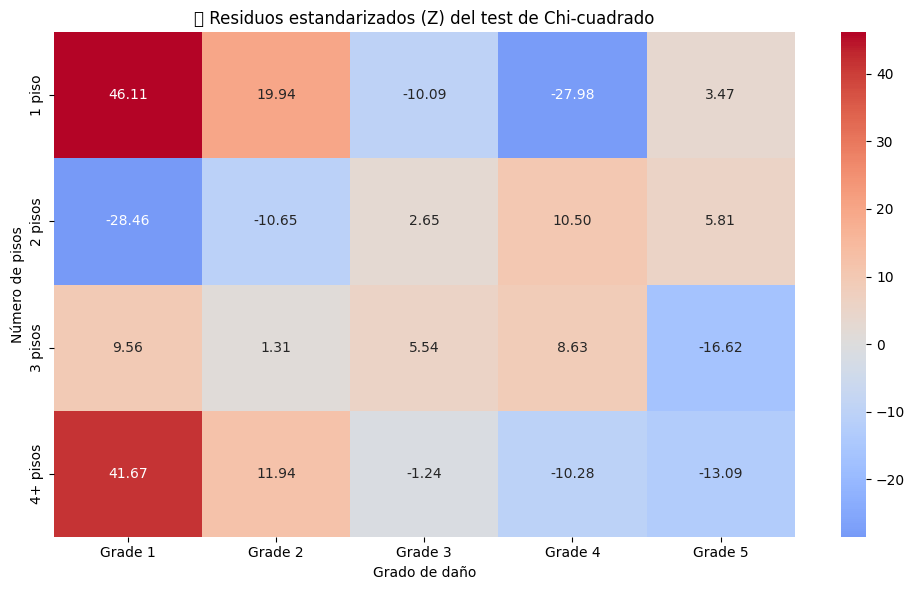

In [ ]:
# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Residuos estandarizados (Z) del test de Chi-cuadrado en el distrito de Gorkha")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [11]:
# Crear el DataFrame con tus datos originales
datos = {
    "Grade 1": [1828, 1622, 618, 283],
    "Grade 2": [1994, 5525, 867, 169],
    "Grade 3": [1835, 11842, 1718, 112],
    "Grade 4": [1748, 18156, 2588, 44],
    "Grade 5": [4281, 21041, 1777, 26]
}
index = ["1 piso", "2 pisos", "3 pisos", "4+ pisos"]

tabla_colapso_pisos = pd.DataFrame(datos, index=index)

# Agregar columnas de colapsó y total
tabla_colapso_pisos["Colapsó"] = tabla_colapso_pisos["Grade 5"]
tabla_colapso_pisos["Total"] = tabla_colapso_pisos.sum(axis=1)

# Calcular intervalos de confianza
resultados = []
z = 1.96  # Z para 95% de confianza

for pisos, row in tabla_colapso_pisos.iterrows():
    colapso = row["Colapsó"]
    total = row["Total"]
    p = colapso / total
    se = np.sqrt(p * (1 - p) / total)
    ic_low = p - z * se
    ic_high = p + z * se
    resultados.append((pisos, p, ic_low, ic_high))

# Convertir a DataFrame
ic_df = pd.DataFrame(resultados, columns=["Pisos", "Proporción", "IC Bajo", "IC Alto"])
print(ic_df)

      Pisos  Proporción   IC Bajo   IC Alto
0    1 piso    0.268115  0.261244  0.274987
1   2 pisos    0.265579  0.262503  0.268654
2   3 pisos    0.190155  0.182199  0.198112
3  4+ pisos    0.039394  0.024553  0.054235


In [14]:
lista_dolakha = nepal[nepal["district_name"] == "DOLAKHA"]

In [15]:
lista_dolakha["pisos_agrupados"] = pd.cut(
    lista_dolakha["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\3674401834.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_dolakha["pisos_agrupados"] = pd.cut(


In [17]:
tabla_contingencia = pd.crosstab(lista_dolakha["pisos_agrupados"], lista_dolakha["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso               448      390      368      541     2298
2 pisos              408     1163     2250     5081    12830
3 pisos              277     1233     3814     8720    20073
4+ pisos             220      207       88       67      163


In [18]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 5818.98
Grados de libertad = 12
p-valor = 0.0000e+00


In [19]:
# Calcular residuos estandarizados
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\3695747132.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inilo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


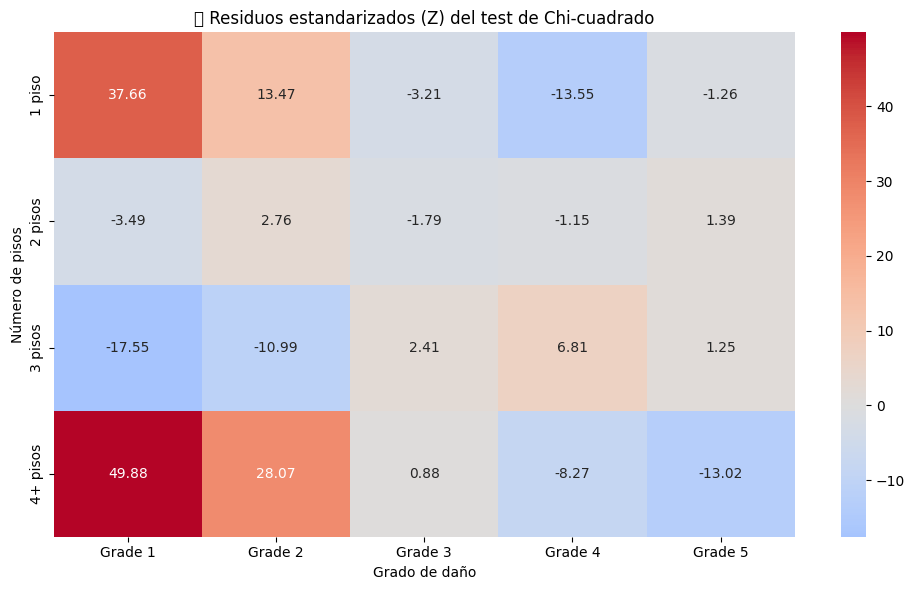

In [20]:
# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("🔍 Residuos estandarizados (Z) del test de Chi-cuadrado")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [21]:
# Crear el DataFrame con tus datos originales
datos = {
    "Grade 1": [448, 408, 277, 220],
    "Grade 2": [390, 1163, 1233, 207],
    "Grade 3": [368, 2250, 3814, 88],
    "Grade 4": [541, 5081, 8720, 67],
    "Grade 5": [2298, 12830, 20073, 163]
}
index = ["1 piso", "2 pisos", "3 pisos", "4+ pisos"]

tabla_colapso_pisos = pd.DataFrame(datos, index=index)

# Agregar columnas de colapsó y total
tabla_colapso_pisos["Colapsó"] = tabla_colapso_pisos["Grade 5"]
tabla_colapso_pisos["Total"] = tabla_colapso_pisos.sum(axis=1)

# Calcular intervalos de confianza
resultados = []
z = 1.96  # Z para 95% de confianza

for pisos, row in tabla_colapso_pisos.iterrows():
    colapso = row["Colapsó"]
    total = row["Total"]
    p = colapso / total
    se = np.sqrt(p * (1 - p) / total)
    ic_low = p - z * se
    ic_high = p + z * se
    resultados.append((pisos, p, ic_low, ic_high))

# Convertir a DataFrame
ic_df = pd.DataFrame(resultados, columns=["Pisos", "Proporción", "IC Bajo", "IC Alto"])
print(ic_df)

      Pisos  Proporción   IC Bajo   IC Alto
0    1 piso    0.362289  0.350460  0.374118
1   2 pisos    0.371217  0.366123  0.376310
2   3 pisos    0.370419  0.366353  0.374485
3  4+ pisos    0.179515  0.154552  0.204479


In [22]:
lista_makwanpur = nepal[nepal["district_name"] == "MAKWANPUR"]

In [23]:
lista_makwanpur["pisos_agrupados"] = pd.cut(
    lista_makwanpur["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\419498621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_makwanpur["pisos_agrupados"] = pd.cut(


In [24]:
tabla_contingencia = pd.crosstab(lista_makwanpur["pisos_agrupados"], lista_makwanpur["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso             16249     8523     4701     2088     2243
2 pisos            14908    11515    12583     8220     5264
3 pisos             1218     1025     1197      601      352
4+ pisos             165       72       44       19        7


In [25]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 5414.20
Grados de libertad = 12
p-valor = 0.0000e+00


In [26]:
# Calcular residuos estandarizados
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\3695747132.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inilo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


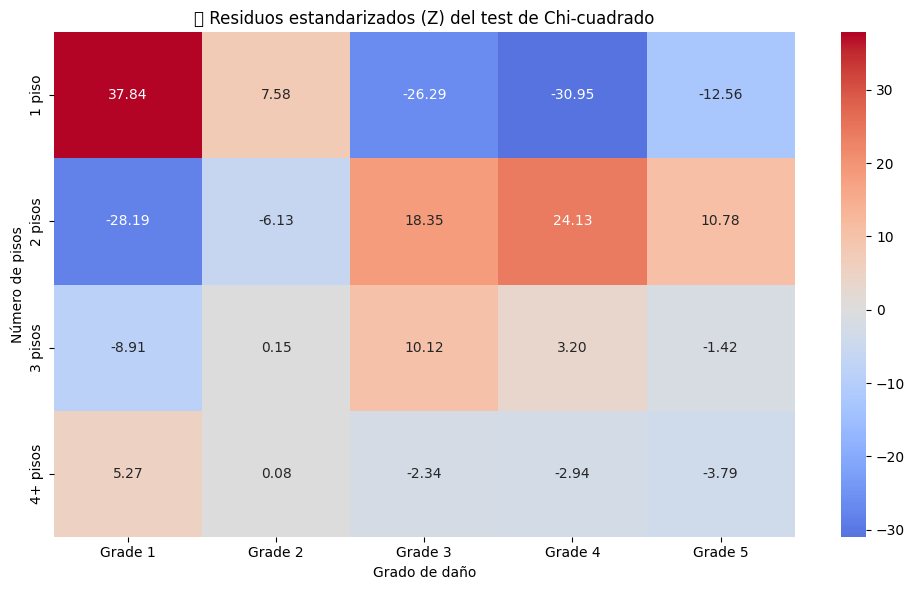

In [27]:
# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("🔍 Residuos estandarizados (Z) del test de Chi-cuadrado")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [28]:
# Crear el DataFrame con tus datos originales
datos = {
    "Grade 1": [16249, 14908, 1218, 165],
    "Grade 2": [8523, 11515, 1025, 72],
    "Grade 3": [4701, 12583, 1197, 44],
    "Grade 4": [2088, 8220, 601, 19],
    "Grade 5": [2243, 5264, 352, 7]
}
index = ["1 piso", "2 pisos", "3 pisos", "4+ pisos"]

tabla_colapso_pisos = pd.DataFrame(datos, index=index)

# Agregar columnas de colapsó y total
tabla_colapso_pisos["Colapsó"] = tabla_colapso_pisos["Grade 5"]
tabla_colapso_pisos["Total"] = tabla_colapso_pisos.sum(axis=1)

# Calcular intervalos de confianza
resultados = []
z = 1.96  # Z para 95% de confianza

for pisos, row in tabla_colapso_pisos.iterrows():
    colapso = row["Colapsó"]
    total = row["Total"]
    p = colapso / total
    se = np.sqrt(p * (1 - p) / total)
    ic_low = p - z * se
    ic_high = p + z * se
    resultados.append((pisos, p, ic_low, ic_high))

# Convertir a DataFrame
ic_df = pd.DataFrame(resultados, columns=["Pisos", "Proporción", "IC Bajo", "IC Alto"])
print(ic_df)

      Pisos  Proporción   IC Bajo   IC Alto
0    1 piso    0.062224  0.059731  0.064718
1   2 pisos    0.091145  0.088798  0.093493
2   3 pisos    0.074183  0.066727  0.081640
3  4+ pisos    0.022293  0.005963  0.038623


In [29]:
lista_rasuwa = nepal[nepal["district_name"] == "RASUWA"]

In [30]:
lista_rasuwa["pisos_agrupados"] = pd.cut(
    lista_rasuwa["count_floors_pre_eq"],
    bins=[0, 1, 2, 3, float("inf")],
    labels=["1 piso", "2 pisos", "3 pisos", "4+ pisos"],
    right=True
)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\3035535953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lista_rasuwa["pisos_agrupados"] = pd.cut(


In [32]:
tabla_contingencia = pd.crosstab(lista_rasuwa["pisos_agrupados"], lista_rasuwa["damage_grade"])
print(tabla_contingencia)

damage_grade     Grade 1  Grade 2  Grade 3  Grade 4  Grade 5
pisos_agrupados                                             
1 piso               101      113      183      374     2269
2 pisos               95      148      477     1439     5812
3 pisos               45       55      103      248     1081
4+ pisos              36       27       19        3       16


In [34]:
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print(f"Chi² = {chi2:.2f}")
print(f"Grados de libertad = {dof}")
print(f"p-valor = {p:.4e}")

Chi² = 956.62
Grados de libertad = 12
p-valor = 3.9515e-197


In [35]:
# Calcular residuos estandarizados
residuos = (tabla_contingencia - expected) / np.sqrt(expected)

C:\Users\inilo\AppData\Local\Temp\ipykernel_18080\3695747132.py:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\inilo\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


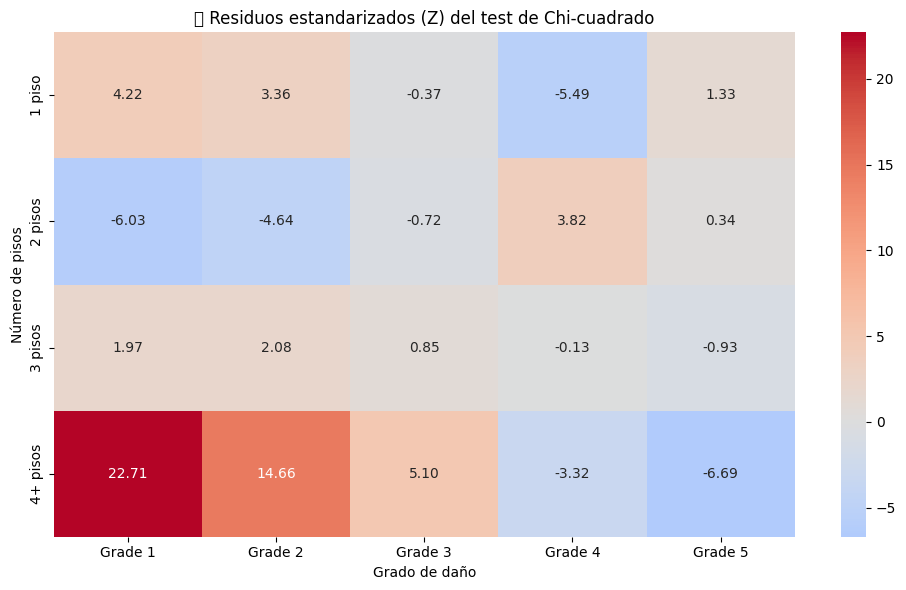

In [36]:
# Crear heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residuos, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("🔍 Residuos estandarizados (Z) del test de Chi-cuadrado")
plt.xlabel("Grado de daño")
plt.ylabel("Número de pisos")
plt.tight_layout()
plt.show()

In [37]:
# Crear el DataFrame con tus datos originales
datos = {
    "Grade 1": [101, 95, 45, 36],
    "Grade 2": [113, 148, 55, 27],
    "Grade 3": [183, 477, 103, 19],
    "Grade 4": [374, 1439, 248, 3],
    "Grade 5": [2269, 5812, 1081, 16]
}
index = ["1 piso", "2 pisos", "3 pisos", "4+ pisos"]

tabla_colapso_pisos = pd.DataFrame(datos, index=index)

# Agregar columnas de colapsó y total
tabla_colapso_pisos["Colapsó"] = tabla_colapso_pisos["Grade 5"]
tabla_colapso_pisos["Total"] = tabla_colapso_pisos.sum(axis=1)

# Calcular intervalos de confianza
resultados = []
z = 1.96  # Z para 95% de confianza

for pisos, row in tabla_colapso_pisos.iterrows():
    colapso = row["Colapsó"]
    total = row["Total"]
    p = colapso / total
    se = np.sqrt(p * (1 - p) / total)
    ic_low = p - z * se
    ic_high = p + z * se
    resultados.append((pisos, p, ic_low, ic_high))

# Convertir a DataFrame
ic_df = pd.DataFrame(resultados, columns=["Pisos", "Proporción", "IC Bajo", "IC Alto"])
print(ic_df)

      Pisos  Proporción   IC Bajo   IC Alto
0    1 piso    0.427387  0.414080  0.440695
1   2 pisos    0.421679  0.413434  0.429923
2   3 pisos    0.413701  0.394817  0.432585
3  4+ pisos    0.136752  0.074494  0.199011
